In [1]:
%cd ..

/home/chickencurry/emb-ml-challenge


In [2]:
import torch
import matplotlib.pyplot as plt
from utils.taylor_pruning import TinyYoloV2WithTaylorRanking, prune_state_dict, get_channels_to_prune_per_layer
from utils.dataloader import VOCDataLoaderPerson
from utils.loss import YoloLoss
from utils.train_eval import validate, train_epoch
from utils.tinyyolov2 import TinyYoloV2Pruned
from utils.metrics import get_size_on_disk

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


In [4]:
# import torch_directml
# device = torch_directml.device()
# print(device)

In [5]:
train_loader = VOCDataLoaderPerson(train=True, batch_size=128, shuffle=True)
val_loader = VOCDataLoaderPerson(train=False, batch_size=1)

In [7]:
# num of kernels to prune = multiplier * model size

def run_taylor_pruning(
        device, 
        train_loader, 
        val_loader, 
        num_of_iterations=10, 
        multiplier=10, 
        num_epochs=10,
        lr=0.0001,
        save_dir="./runs/taylor2", 
        initial_load_path="./runs/voc_person_only.pt",
        start_index=0):
    
    final_val_aps = []
    model_sizes = []
    
    for i in range(num_of_iterations):
        n = i + start_index

        load_path = f'{save_dir}/voc_pruned_{n-1}_finetuned.pt' if i > 0 else initial_load_path
        print(f"load_path: {load_path}")

        state_dict = torch.load(load_path)
        net = TinyYoloV2WithTaylorRanking(device, num_classes=1)
        net.load_state_dict(state_dict, strict=False)

        criterion = YoloLoss(anchors=net.anchors)

        model_size = get_size_on_disk(net.state_dict())
        print(f"model_size: {model_size}")
        model_sizes.append(model_size)

        num_of_filters_to_prune = int(multiplier * model_size)
        print(f"num_of_filters_to_prune: {num_of_filters_to_prune}")
        feature_maps_to_prune = get_channels_to_prune_per_layer(net, criterion, train_loader, device, num_of_filters_to_prune)
        state_dict = prune_state_dict(state_dict, feature_maps_to_prune)

        net = TinyYoloV2Pruned(num_classes=1)
        net.load_state_dict(state_dict, strict=False)

        ap_after_pruning = validate(net, device, val_loader, roc=False)
        print(f"ap_after_pruning: {ap_after_pruning}")

        torch.save(net.state_dict(), f'{save_dir}/voc_pruned_{n}.pt')

        for key, param in net.named_parameters():
            if any(x in key for x in ['1', '2', '3', '4', '5', '6', '7']):
                param.requires_grad = False
            elif any(x in key for x in ["8", "9"]):
                param.requires_grad = True
        params_to_train = filter(lambda x: x.requires_grad, net.parameters())

        criterion = YoloLoss(anchors=net.anchors)
        optimizer = torch.optim.Adam(params_to_train, lr=lr) # lr=0.001)

        val_aps = []
        avg_losses = []
        max_val_ap = ap_after_pruning

        for epoch in range(num_epochs):
            
            avg_loss = train_epoch(net, optimizer, criterion, device, train_loader)
            avg_losses.append(avg_loss)

            val_ap = validate(net, device, val_loader, roc=False)
            val_aps.append(val_ap)
            print(f"at epoch {epoch}, val_ap: {val_ap}")

            if val_ap > max_val_ap:
                max_val_ap = val_ap
                print("new max_val_ap")
                torch.save(net.state_dict(), f'{save_dir}/voc_pruned_{n}_finetuned.pt')

        final_val_aps.append(max_val_ap)
                
        plt.subplot(1, 2, 1)
        plt.plot(val_aps)
        plt.title("Validation AP")
        plt.xlabel("Epoch")
        plt.ylabel("AP")

        plt.subplot(1, 2, 2)
        plt.plot(avg_losses)
        plt.title("Average Loss")
        plt.xlabel("Epoch")
        plt.ylabel("Average Loss")
        plt.show()

        print(f"val_aps: {val_aps}")
        print(f"avg_losses: {avg_losses}")

    return final_val_aps, model_sizes

load_path: ./runs/voc_person_only.pt
model_size: 70.800601
num_of_filters_to_prune: 708


  0%|          | 0/17 [00:00<?, ?it/s]/home/chickencurry/miniconda3/envs/torch-directml/lib/python3.8/site-packages/torch/functional.py:512: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3587.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
100%|██████████| 17/17 [02:11<00:00,  7.76s/it]


[0, 0, 0, 0, 8, 38, 231, 431, 0]


100%|██████████| 350/350 [00:24<00:00, 14.20it/s]


ap_after_pruning: 0.5006759153362929


100%|██████████| 350/350 [00:19<00:00, 17.85it/s]


at epoch 0, val_ap: 0.541032871107491
new max_val_ap


100%|██████████| 350/350 [00:19<00:00, 17.61it/s]


at epoch 1, val_ap: 0.5595383173564769
new max_val_ap


100%|██████████| 350/350 [00:20<00:00, 17.21it/s]


at epoch 2, val_ap: 0.5701778977739781
new max_val_ap


100%|██████████| 350/350 [00:19<00:00, 17.90it/s]


at epoch 3, val_ap: 0.5737797802355616
new max_val_ap


100%|██████████| 350/350 [00:19<00:00, 17.84it/s]


at epoch 4, val_ap: 0.5940167119027345
new max_val_ap


100%|██████████| 350/350 [00:19<00:00, 18.01it/s]


at epoch 5, val_ap: 0.5989202942235586
new max_val_ap


100%|██████████| 350/350 [00:19<00:00, 18.37it/s]


at epoch 6, val_ap: 0.6142950965527381
new max_val_ap


100%|██████████| 350/350 [00:19<00:00, 17.94it/s]


at epoch 7, val_ap: 0.6320385553478648
new max_val_ap


100%|██████████| 350/350 [00:19<00:00, 18.11it/s]


at epoch 8, val_ap: 0.6124562140360615


100%|██████████| 350/350 [00:19<00:00, 17.90it/s]


at epoch 9, val_ap: 0.6104757954460104


100%|██████████| 350/350 [00:19<00:00, 17.95it/s]


at epoch 10, val_ap: 0.6148152764367941


100%|██████████| 350/350 [00:19<00:00, 17.69it/s]


at epoch 11, val_ap: 0.6201605340718628


100%|██████████| 350/350 [00:19<00:00, 17.95it/s]


at epoch 12, val_ap: 0.6230602017064301


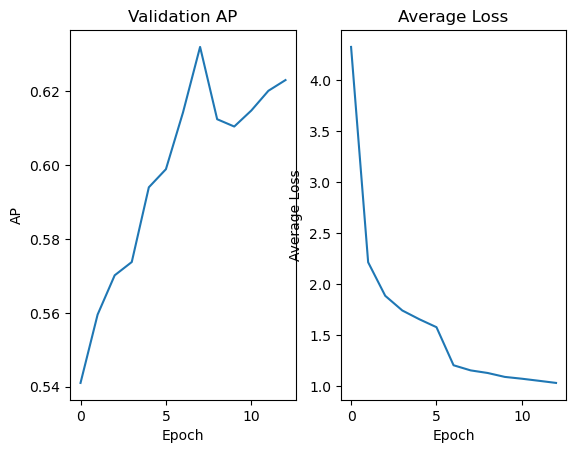

val_aps: [0.541032871107491, 0.5595383173564769, 0.5701778977739781, 0.5737797802355616, 0.5940167119027345, 0.5989202942235586, 0.6142950965527381, 0.6320385553478648, 0.6124562140360615, 0.6104757954460104, 0.6148152764367941, 0.6201605340718628, 0.6230602017064301]
avg_losses: [4.32381199387943, 2.215713416828829, 1.8875468478483313, 1.7438643820145552, 1.657773817286772, 1.5803546765271355, 1.2076764737858492, 1.157463129828958, 1.1319694378796745, 1.093687141642851, 1.0759200103142683, 1.055617423618541, 1.0347751589382397]
load_path: ./runs/taylor2/voc_pruned_0_finetuned.pt
model_size: 40.773437
num_of_filters_to_prune: 407


100%|██████████| 17/17 [01:51<00:00,  6.58s/it]


[0, 0, 0, 0, 3, 16, 133, 255, 0]


100%|██████████| 350/350 [00:23<00:00, 15.13it/s]


ap_after_pruning: 0.5761622809060385


100%|██████████| 350/350 [00:19<00:00, 18.42it/s]


at epoch 0, val_ap: 0.5177695833360569


100%|██████████| 350/350 [00:18<00:00, 18.94it/s]


at epoch 1, val_ap: 0.5791254387213983
new max_val_ap


100%|██████████| 350/350 [00:18<00:00, 19.07it/s]


at epoch 2, val_ap: 0.5629125879666229


100%|██████████| 350/350 [00:17<00:00, 19.49it/s]


at epoch 3, val_ap: 0.602400031692961
new max_val_ap


100%|██████████| 350/350 [00:17<00:00, 19.50it/s]


at epoch 4, val_ap: 0.5694489838224017


100%|██████████| 350/350 [00:18<00:00, 19.19it/s]


at epoch 5, val_ap: 0.5791767746457607


100%|██████████| 350/350 [00:17<00:00, 19.52it/s]


at epoch 6, val_ap: 0.6364176735608443
new max_val_ap


100%|██████████| 350/350 [00:18<00:00, 19.22it/s]


at epoch 7, val_ap: 0.6357847956527055


100%|██████████| 350/350 [00:18<00:00, 18.66it/s]


at epoch 8, val_ap: 0.6059798084544945


100%|██████████| 350/350 [00:18<00:00, 18.59it/s]


at epoch 9, val_ap: 0.6286778611759186


100%|██████████| 350/350 [00:18<00:00, 18.50it/s]


at epoch 10, val_ap: 0.6221945692225412


100%|██████████| 350/350 [00:19<00:00, 18.40it/s]


at epoch 11, val_ap: 0.6243244093671444


100%|██████████| 350/350 [00:19<00:00, 18.35it/s]


at epoch 12, val_ap: 0.5986423065212647


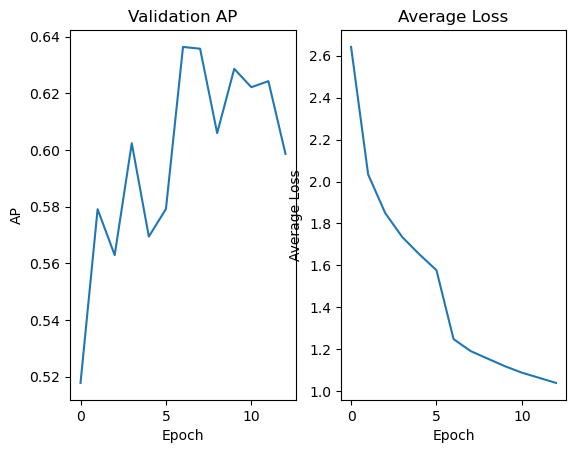

val_aps: [0.5177695833360569, 0.5791254387213983, 0.5629125879666229, 0.602400031692961, 0.5694489838224017, 0.5791767746457607, 0.6364176735608443, 0.6357847956527055, 0.6059798084544945, 0.6286778611759186, 0.6221945692225412, 0.6243244093671444, 0.5986423065212647]
avg_losses: [2.642051668728099, 2.033715809092802, 1.8494243972441728, 1.7347649546230541, 1.6526082964504467, 1.5769498768974752, 1.248320881058188, 1.1912204447914572, 1.155051399679745, 1.1192194784388823, 1.0881718888002283, 1.063815243103925, 1.039281189441681]
load_path: ./runs/taylor2/voc_pruned_1_finetuned.pt
model_size: 27.547717
num_of_filters_to_prune: 275


100%|██████████| 17/17 [01:48<00:00,  6.37s/it]


[0, 0, 0, 0, 6, 49, 110, 110, 0]


100%|██████████| 350/350 [00:24<00:00, 14.48it/s]


ap_after_pruning: 0.5182840356812483


100%|██████████| 350/350 [00:20<00:00, 17.36it/s]


at epoch 0, val_ap: 0.5018701478845669


100%|██████████| 350/350 [00:18<00:00, 19.01it/s]


at epoch 1, val_ap: 0.5380421632449314
new max_val_ap


100%|██████████| 350/350 [00:18<00:00, 18.94it/s]


at epoch 2, val_ap: 0.5488611068186681
new max_val_ap


100%|██████████| 350/350 [00:17<00:00, 19.94it/s]


at epoch 3, val_ap: 0.5569335504346872
new max_val_ap


100%|██████████| 350/350 [00:18<00:00, 19.40it/s]


at epoch 4, val_ap: 0.5601076259026259
new max_val_ap


100%|██████████| 350/350 [00:17<00:00, 19.81it/s]


at epoch 5, val_ap: 0.5640656819330422
new max_val_ap


100%|██████████| 350/350 [00:17<00:00, 19.79it/s]


at epoch 6, val_ap: 0.5682833018312177
new max_val_ap


100%|██████████| 350/350 [00:18<00:00, 19.37it/s]


at epoch 7, val_ap: 0.5696717089667178
new max_val_ap


100%|██████████| 350/350 [00:18<00:00, 19.25it/s]


at epoch 8, val_ap: 0.5670949269758224


100%|██████████| 350/350 [00:17<00:00, 19.45it/s]


at epoch 9, val_ap: 0.5915520258407657
new max_val_ap


100%|██████████| 350/350 [00:18<00:00, 19.40it/s]


at epoch 10, val_ap: 0.576379715978019


100%|██████████| 350/350 [00:18<00:00, 19.14it/s]


at epoch 11, val_ap: 0.5926987808830044
new max_val_ap


100%|██████████| 350/350 [00:18<00:00, 19.16it/s]


at epoch 12, val_ap: 0.5927327720991016
new max_val_ap


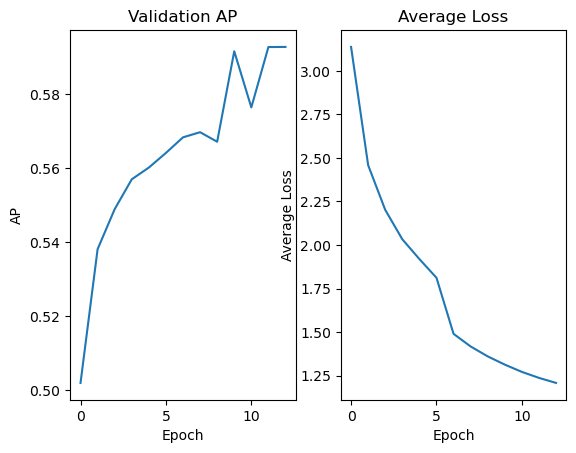

val_aps: [0.5018701478845669, 0.5380421632449314, 0.5488611068186681, 0.5569335504346872, 0.5601076259026259, 0.5640656819330422, 0.5682833018312177, 0.5696717089667178, 0.5670949269758224, 0.5915520258407657, 0.576379715978019, 0.5926987808830044, 0.5927327720991016]
avg_losses: [3.1373006596284756, 2.4581798244925106, 2.201746660120347, 2.0328889454112335, 1.9192439387826359, 1.8118632260490866, 1.4898471060921163, 1.4174768153358908, 1.360416335218093, 1.3132231796489042, 1.271416846443625, 1.2370065871407003, 1.2080817152472103]
load_path: ./runs/taylor2/voc_pruned_2_finetuned.pt
model_size: 19.839901
num_of_filters_to_prune: 198


100%|██████████| 17/17 [01:41<00:00,  5.97s/it]


[0, 0, 0, 2, 2, 40, 118, 36, 0]


100%|██████████| 350/350 [00:19<00:00, 18.22it/s]


ap_after_pruning: 0.5485888157090174


100%|██████████| 350/350 [00:17<00:00, 20.49it/s]


at epoch 0, val_ap: 0.5562153637257273
new max_val_ap


100%|██████████| 350/350 [00:16<00:00, 20.91it/s]


at epoch 1, val_ap: 0.5644168900002078
new max_val_ap


100%|██████████| 350/350 [00:17<00:00, 20.32it/s]


at epoch 2, val_ap: 0.5637608156229212


100%|██████████| 350/350 [00:17<00:00, 20.58it/s]


at epoch 3, val_ap: 0.572640755410655
new max_val_ap


100%|██████████| 350/350 [00:16<00:00, 20.75it/s]


at epoch 4, val_ap: 0.5722879604772735


100%|██████████| 350/350 [00:17<00:00, 20.28it/s]


at epoch 5, val_ap: 0.5683550531718464


100%|██████████| 350/350 [00:17<00:00, 20.31it/s]


at epoch 6, val_ap: 0.5875940728592052
new max_val_ap


100%|██████████| 350/350 [00:17<00:00, 20.30it/s]


at epoch 7, val_ap: 0.5891921603017715
new max_val_ap


100%|██████████| 350/350 [00:17<00:00, 19.53it/s]


at epoch 8, val_ap: 0.5986474697785772
new max_val_ap


100%|██████████| 350/350 [00:17<00:00, 20.12it/s]


at epoch 9, val_ap: 0.5991628212491968
new max_val_ap


100%|██████████| 350/350 [00:17<00:00, 20.09it/s]


at epoch 10, val_ap: 0.6009838927773773
new max_val_ap


100%|██████████| 350/350 [00:17<00:00, 20.14it/s]


at epoch 11, val_ap: 0.5945281797580428


100%|██████████| 350/350 [00:17<00:00, 19.94it/s]


at epoch 12, val_ap: 0.5960073432243409


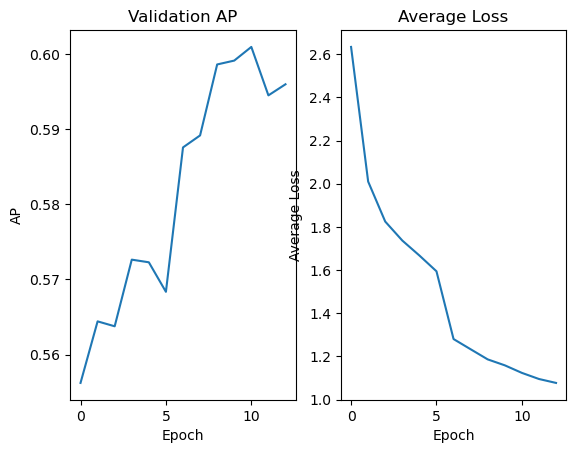

val_aps: [0.5562153637257273, 0.5644168900002078, 0.5637608156229212, 0.572640755410655, 0.5722879604772735, 0.5683550531718464, 0.5875940728592052, 0.5891921603017715, 0.5986474697785772, 0.5991628212491968, 0.6009838927773773, 0.5945281797580428, 0.5960073432243409]
avg_losses: [2.633598566055298, 2.010188677731682, 1.8248569334254545, 1.7369344444835888, 1.6677035443923052, 1.5945833079955156, 1.2807902167825138, 1.233517562641817, 1.1865989951526417, 1.1591372454867643, 1.1241325210122501, 1.0958075348068685, 1.0776328023742228]
load_path: ./runs/taylor2/voc_pruned_3_finetuned.pt
model_size: 15.011257
num_of_filters_to_prune: 150


100%|██████████| 17/17 [01:37<00:00,  5.71s/it]


[0, 0, 0, 1, 4, 34, 73, 38, 0]


100%|██████████| 350/350 [00:19<00:00, 18.07it/s]


ap_after_pruning: 0.5354395655173833


100%|██████████| 350/350 [00:18<00:00, 19.25it/s]


at epoch 0, val_ap: 0.5440745286215217
new max_val_ap


100%|██████████| 350/350 [00:17<00:00, 19.77it/s]


at epoch 1, val_ap: 0.5580527562371433
new max_val_ap


100%|██████████| 350/350 [00:17<00:00, 20.29it/s]


at epoch 2, val_ap: 0.5707092215663448
new max_val_ap


100%|██████████| 350/350 [00:17<00:00, 20.18it/s]


at epoch 3, val_ap: 0.5674917074918773


100%|██████████| 350/350 [00:17<00:00, 20.49it/s]


at epoch 4, val_ap: 0.5716392834207756
new max_val_ap


100%|██████████| 350/350 [00:17<00:00, 20.48it/s]


at epoch 5, val_ap: 0.5679909893272174


100%|██████████| 350/350 [00:17<00:00, 20.39it/s]


at epoch 6, val_ap: 0.5908223447725979
new max_val_ap


100%|██████████| 350/350 [00:17<00:00, 20.44it/s]


at epoch 7, val_ap: 0.5925906985748552
new max_val_ap


100%|██████████| 350/350 [00:17<00:00, 20.10it/s]


at epoch 8, val_ap: 0.5940786465783762
new max_val_ap


100%|██████████| 350/350 [00:18<00:00, 19.43it/s]


at epoch 9, val_ap: 0.5945709561812522
new max_val_ap


100%|██████████| 350/350 [00:17<00:00, 19.51it/s]


at epoch 10, val_ap: 0.5928097097309977


100%|██████████| 350/350 [00:18<00:00, 19.29it/s]


at epoch 11, val_ap: 0.5968503033814281
new max_val_ap


100%|██████████| 350/350 [00:18<00:00, 19.26it/s]


at epoch 12, val_ap: 0.6059839059859388
new max_val_ap


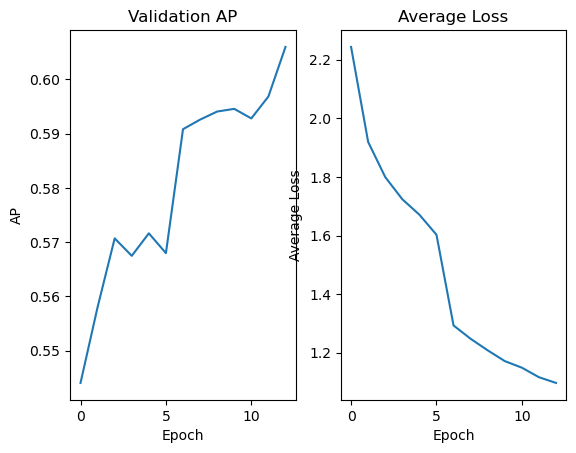

val_aps: [0.5440745286215217, 0.5580527562371433, 0.5707092215663448, 0.5674917074918773, 0.5716392834207756, 0.5679909893272174, 0.5908223447725979, 0.5925906985748552, 0.5940786465783762, 0.5945709561812522, 0.5928097097309977, 0.5968503033814281, 0.6059839059859388]
avg_losses: [2.243581820936764, 1.9193774531869328, 1.7995063487221212, 1.7238095507902258, 1.6710813746732824, 1.602797367993523, 1.293131898431217, 1.2476947868571562, 1.208223952966578, 1.171547433909248, 1.1491099455777336, 1.1165908224442427, 1.0971178342314327]
load_path: ./runs/taylor2/voc_pruned_4_finetuned.pt
model_size: 11.890426
num_of_filters_to_prune: 118


100%|██████████| 17/17 [01:40<00:00,  5.90s/it]


[0, 0, 0, 0, 15, 33, 64, 6, 0]


100%|██████████| 350/350 [00:17<00:00, 20.11it/s]


ap_after_pruning: 0.4925387588686162


100%|██████████| 350/350 [00:17<00:00, 20.35it/s]


at epoch 0, val_ap: 0.5680866598338101
new max_val_ap


100%|██████████| 350/350 [00:17<00:00, 20.25it/s]


at epoch 1, val_ap: 0.5624677003904301


100%|██████████| 350/350 [00:16<00:00, 20.70it/s]


at epoch 2, val_ap: 0.5692943375115072
new max_val_ap


100%|██████████| 350/350 [00:16<00:00, 20.71it/s]


at epoch 3, val_ap: 0.5801095565378703
new max_val_ap


100%|██████████| 350/350 [00:16<00:00, 21.00it/s]


at epoch 4, val_ap: 0.5420254228631319


100%|██████████| 350/350 [00:16<00:00, 21.20it/s]


at epoch 5, val_ap: 0.5357411988206155


100%|██████████| 350/350 [00:16<00:00, 20.63it/s]


at epoch 6, val_ap: 0.5595516969497791


100%|██████████| 350/350 [00:16<00:00, 21.20it/s]


at epoch 7, val_ap: 0.5995833611836221
new max_val_ap


100%|██████████| 350/350 [00:17<00:00, 20.45it/s]


at epoch 8, val_ap: 0.5997381741225273
new max_val_ap


100%|██████████| 350/350 [00:17<00:00, 20.55it/s]


at epoch 9, val_ap: 0.5973878478221444


100%|██████████| 350/350 [00:17<00:00, 20.19it/s]


at epoch 10, val_ap: 0.5930932448089311


100%|██████████| 350/350 [00:17<00:00, 20.18it/s]


at epoch 11, val_ap: 0.594851327496853


100%|██████████| 350/350 [00:17<00:00, 20.24it/s]


at epoch 12, val_ap: 0.5971500858514903


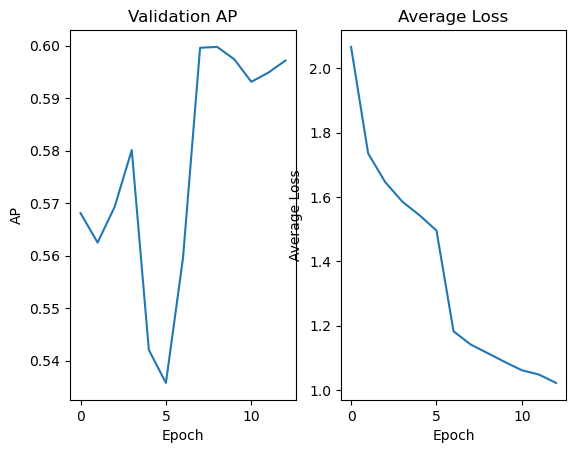

val_aps: [0.5680866598338101, 0.5624677003904301, 0.5692943375115072, 0.5801095565378703, 0.5420254228631319, 0.5357411988206155, 0.5595516969497791, 0.5995833611836221, 0.5997381741225273, 0.5973878478221444, 0.5930932448089311, 0.594851327496853, 0.5971500858514903]
avg_losses: [2.06640728782205, 1.7353111014646643, 1.6461446285247803, 1.5854694001814897, 1.5434759013793047, 1.495698381872738, 1.1824367256725536, 1.1413978338241577, 1.114488521042992, 1.0871821501675774, 1.0613573474042557, 1.0479566034148722, 1.0219792092547697]
load_path: ./runs/taylor2/voc_pruned_5_finetuned.pt
model_size: 9.584221
num_of_filters_to_prune: 95


100%|██████████| 17/17 [01:35<00:00,  5.64s/it]


[0, 0, 0, 1, 9, 30, 40, 15, 0]


100%|██████████| 350/350 [00:17<00:00, 20.04it/s]


ap_after_pruning: 0.5299078569212976


100%|██████████| 350/350 [00:17<00:00, 20.39it/s]


at epoch 0, val_ap: 0.5555920205249772
new max_val_ap


100%|██████████| 350/350 [00:17<00:00, 20.51it/s]


at epoch 1, val_ap: 0.5655218520541649
new max_val_ap


100%|██████████| 350/350 [00:17<00:00, 20.25it/s]


at epoch 2, val_ap: 0.5708373573020108
new max_val_ap


100%|██████████| 350/350 [00:16<00:00, 20.61it/s]


at epoch 3, val_ap: 0.5353285380451658


100%|██████████| 350/350 [00:17<00:00, 20.51it/s]


at epoch 4, val_ap: 0.5385346991482947


100%|██████████| 350/350 [00:17<00:00, 20.22it/s]


at epoch 5, val_ap: 0.5288429826732126


100%|██████████| 350/350 [00:17<00:00, 20.30it/s]


at epoch 6, val_ap: 0.5770771854556412
new max_val_ap


100%|██████████| 350/350 [00:16<00:00, 20.64it/s]


at epoch 7, val_ap: 0.586750124862228
new max_val_ap


100%|██████████| 350/350 [00:17<00:00, 20.47it/s]


at epoch 8, val_ap: 0.594196305310036
new max_val_ap


100%|██████████| 350/350 [00:17<00:00, 20.19it/s]


at epoch 9, val_ap: 0.5815965181938606


100%|██████████| 350/350 [00:17<00:00, 20.18it/s]


at epoch 10, val_ap: 0.5937882359716653


100%|██████████| 350/350 [00:18<00:00, 19.26it/s]


at epoch 11, val_ap: 0.5954849547028723
new max_val_ap


100%|██████████| 350/350 [00:18<00:00, 19.26it/s]


at epoch 12, val_ap: 0.5941310861528758


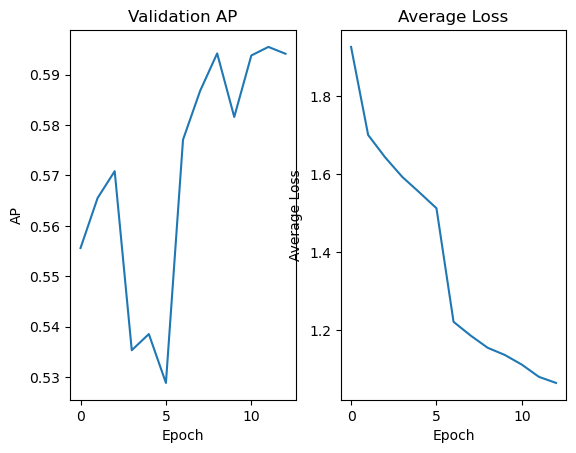

val_aps: [0.5555920205249772, 0.5655218520541649, 0.5708373573020108, 0.5353285380451658, 0.5385346991482947, 0.5288429826732126, 0.5770771854556412, 0.586750124862228, 0.594196305310036, 0.5815965181938606, 0.5937882359716653, 0.5954849547028723, 0.5941310861528758]
avg_losses: [1.9269443189396578, 1.7010495522442985, 1.6433939372791964, 1.5934648163178389, 1.5537833676618689, 1.5131159459843355, 1.2218552897958195, 1.1866097239887012, 1.1552119395312141, 1.1368822560590857, 1.1119862233891207, 1.080669006880592, 1.0651197047794567]
load_path: ./runs/taylor2/voc_pruned_6_finetuned.pt
model_size: 7.968716
num_of_filters_to_prune: 79


100%|██████████| 17/17 [01:37<00:00,  5.75s/it]


[1, 0, 0, 1, 11, 20, 36, 10, 0]


100%|██████████| 350/350 [00:17<00:00, 19.95it/s]


ap_after_pruning: 0.4409549639345048


100%|██████████| 350/350 [00:16<00:00, 20.64it/s]


at epoch 0, val_ap: 0.5076786657805225
new max_val_ap


100%|██████████| 350/350 [00:16<00:00, 20.77it/s]


at epoch 1, val_ap: 0.5278253488362289
new max_val_ap


100%|██████████| 350/350 [00:17<00:00, 20.46it/s]


at epoch 2, val_ap: 0.5243765793235934


100%|██████████| 350/350 [00:16<00:00, 20.96it/s]


at epoch 3, val_ap: 0.5298394291622249
new max_val_ap


100%|██████████| 350/350 [00:16<00:00, 20.69it/s]


at epoch 4, val_ap: 0.5300598848844462
new max_val_ap


100%|██████████| 350/350 [00:16<00:00, 20.74it/s]


at epoch 5, val_ap: 0.532891688220954
new max_val_ap


100%|██████████| 350/350 [00:16<00:00, 20.89it/s]


at epoch 6, val_ap: 0.5314663061339931


100%|██████████| 350/350 [00:17<00:00, 20.57it/s]


at epoch 7, val_ap: 0.5312988571642946


100%|██████████| 350/350 [00:17<00:00, 19.87it/s]


at epoch 8, val_ap: 0.5319737774671729


100%|██████████| 350/350 [00:17<00:00, 20.40it/s]


at epoch 9, val_ap: 0.5416627003340172
new max_val_ap


100%|██████████| 350/350 [00:17<00:00, 20.33it/s]


at epoch 10, val_ap: 0.5399131637858541


100%|██████████| 350/350 [00:17<00:00, 20.08it/s]


at epoch 11, val_ap: 0.5396822269920246


100%|██████████| 350/350 [00:17<00:00, 20.10it/s]


at epoch 12, val_ap: 0.5453894079054605
new max_val_ap


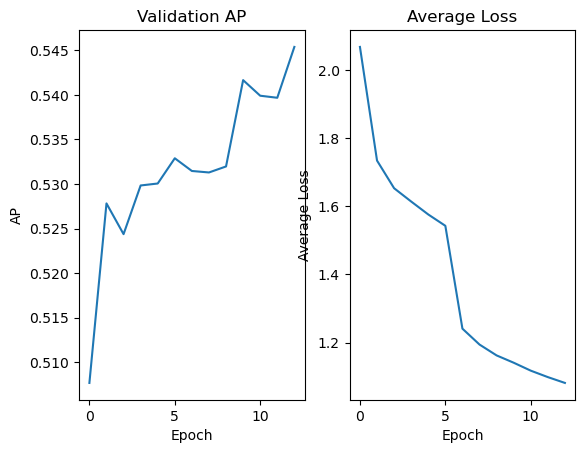

val_aps: [0.5076786657805225, 0.5278253488362289, 0.5243765793235934, 0.5298394291622249, 0.5300598848844462, 0.532891688220954, 0.5314663061339931, 0.5312988571642946, 0.5319737774671729, 0.5416627003340172, 0.5399131637858541, 0.5396822269920246, 0.5453894079054605]
avg_losses: [2.068159454009112, 1.7344629624310661, 1.653236753800336, 1.6141763855429256, 1.5761927997364718, 1.5429194043664372, 1.2409166658625883, 1.1942811783622294, 1.162395112654742, 1.140940448817085, 1.1176275365492876, 1.0986919438137728, 1.08159638152403]
load_path: ./runs/taylor2/voc_pruned_7_finetuned.pt
model_size: 6.762923
num_of_filters_to_prune: 67


100%|██████████| 17/17 [01:34<00:00,  5.55s/it]


[0, 0, 0, 2, 11, 20, 30, 4, 0]


100%|██████████| 350/350 [00:17<00:00, 20.56it/s]


ap_after_pruning: 0.5036659144103287


100%|██████████| 350/350 [00:16<00:00, 20.88it/s]


at epoch 0, val_ap: 0.49845303375976324


100%|██████████| 350/350 [00:16<00:00, 20.95it/s]


at epoch 1, val_ap: 0.5039258594153435
new max_val_ap


100%|██████████| 350/350 [00:16<00:00, 21.05it/s]


at epoch 2, val_ap: 0.5056449759787046
new max_val_ap


100%|██████████| 350/350 [00:16<00:00, 20.99it/s]


at epoch 3, val_ap: 0.5074141951180254
new max_val_ap


100%|██████████| 350/350 [00:17<00:00, 20.57it/s]


at epoch 4, val_ap: 0.5035377376942921


100%|██████████| 350/350 [00:16<00:00, 20.74it/s]


at epoch 5, val_ap: 0.5231358265563281
new max_val_ap


100%|██████████| 350/350 [00:16<00:00, 20.83it/s]


at epoch 6, val_ap: 0.5064219701608343


100%|██████████| 350/350 [00:17<00:00, 20.56it/s]


at epoch 7, val_ap: 0.5037183131702324


100%|██████████| 350/350 [00:16<00:00, 20.74it/s]


at epoch 8, val_ap: 0.5001526772284817


100%|██████████| 350/350 [00:16<00:00, 20.63it/s]


at epoch 9, val_ap: 0.5016039664379757


100%|██████████| 350/350 [00:16<00:00, 21.67it/s]


at epoch 10, val_ap: 0.5332229622190904
new max_val_ap


100%|██████████| 350/350 [00:16<00:00, 20.81it/s]


at epoch 11, val_ap: 0.5058312487876839


100%|██████████| 350/350 [00:17<00:00, 20.15it/s]


at epoch 12, val_ap: 0.5125857179350556


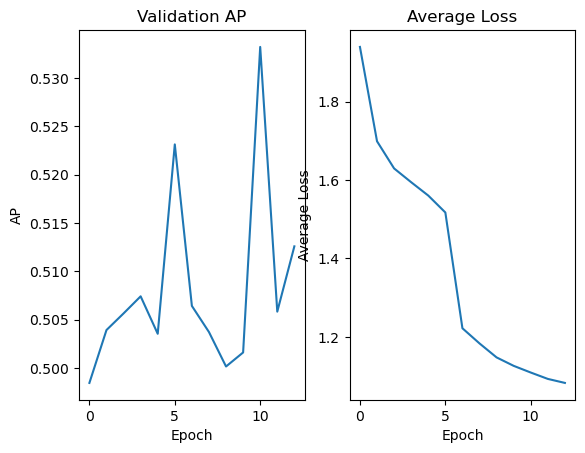

val_aps: [0.49845303375976324, 0.5039258594153435, 0.5056449759787046, 0.5074141951180254, 0.5035377376942921, 0.5231358265563281, 0.5064219701608343, 0.5037183131702324, 0.5001526772284817, 0.5016039664379757, 0.5332229622190904, 0.5058312487876839, 0.5125857179350556]
avg_losses: [1.9391312529059017, 1.6987046003341675, 1.6294731602949255, 1.5943350090700037, 1.5603503409553976, 1.517259857233833, 1.2221891319050509, 1.1835885538774378, 1.147924640599419, 1.1264400131562178, 1.1093947396558874, 1.0931361773434807, 1.0829168663305395]
load_path: ./runs/taylor2/voc_pruned_8_finetuned.pt
model_size: 5.783516
num_of_filters_to_prune: 57


100%|██████████| 17/17 [01:44<00:00,  6.12s/it]


[0, 0, 0, 4, 12, 15, 24, 2, 0]


100%|██████████| 350/350 [00:17<00:00, 19.90it/s]


ap_after_pruning: 0.48854375513503895


100%|██████████| 350/350 [00:16<00:00, 21.00it/s]


at epoch 0, val_ap: 0.514569200234578
new max_val_ap


100%|██████████| 350/350 [00:16<00:00, 20.88it/s]


at epoch 1, val_ap: 0.5238608173961662
new max_val_ap


100%|██████████| 350/350 [00:16<00:00, 20.96it/s]


at epoch 2, val_ap: 0.5039349310161518


100%|██████████| 350/350 [00:16<00:00, 20.76it/s]


at epoch 3, val_ap: 0.4995545570593562


100%|██████████| 350/350 [00:16<00:00, 20.82it/s]


at epoch 4, val_ap: 0.4976457216052092


100%|██████████| 350/350 [00:16<00:00, 20.67it/s]


at epoch 5, val_ap: 0.49736436671457157


100%|██████████| 350/350 [00:16<00:00, 20.79it/s]


at epoch 6, val_ap: 0.5079895226880342


100%|██████████| 350/350 [00:16<00:00, 20.74it/s]


at epoch 7, val_ap: 0.5262472411834346
new max_val_ap


100%|██████████| 350/350 [00:16<00:00, 20.87it/s]


at epoch 8, val_ap: 0.5063417513169558


100%|██████████| 350/350 [00:16<00:00, 20.68it/s]


at epoch 9, val_ap: 0.5255746933642406


100%|██████████| 350/350 [00:16<00:00, 20.74it/s]


at epoch 10, val_ap: 0.5111350700654942


100%|██████████| 350/350 [00:17<00:00, 20.26it/s]


at epoch 11, val_ap: 0.5152949174509216


100%|██████████| 350/350 [00:17<00:00, 20.13it/s]


at epoch 12, val_ap: 0.507355661455027


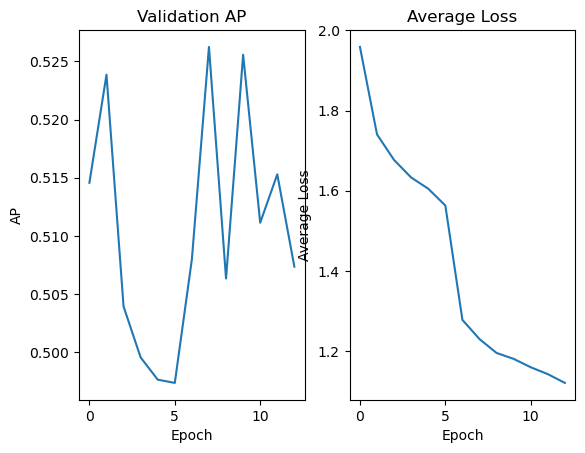

val_aps: [0.514569200234578, 0.5238608173961662, 0.5039349310161518, 0.4995545570593562, 0.4976457216052092, 0.49736436671457157, 0.5079895226880342, 0.5262472411834346, 0.5063417513169558, 0.5255746933642406, 0.5111350700654942, 0.5152949174509216, 0.507355661455027]
avg_losses: [1.9588118160472197, 1.7404782281202429, 1.6767086702234604, 1.633061927907607, 1.6050938367843628, 1.563221672002007, 1.2779322231517118, 1.2300698546802296, 1.195453173973981, 1.180695470641641, 1.1598076750250423, 1.1426340131198658, 1.1207261926987593]


In [8]:
final_val_aps, model_sizes = run_taylor_pruning(
    device, 
    train_loader, 
    val_loader, 
    num_of_iterations=10, 
    multiplier=10, 
    num_epochs=13,
    lr=0.0001,
    save_dir="./runs/taylor2",
    initial_load_path="./runs/voc_person_only.pt",
)